<a id="tercero"></a>
## 3. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante dificil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos con corresponden a 3640 imágenes de Flickr de rostros de personas, pero, debido a que trabajamos con redes *feed forward*, se trabajará con representaciones de características extraídas. Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification* o a través de la consola Unix.
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/ageGenderClassification.zip
```

Se trabajará con archivos *.mat* que pueden ser cargados de la siguiente manera:
```python
import scipy.io as sio
sio.loadmat("file.mat")
```

Para descripción sobre las columnas están en el archivo readme a través del siguiente __[link](http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt)__ o a través de la consola Unix:
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt
```



a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?

In [366]:
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

In [372]:
print('Cantidad de datos de entrenamiento: ',data_train[0].shape[0])
print('Cantidad de datos de prueba: ',data_test[0].shape[0])

Cantidad de datos de entrenamiento:  3500
Cantidad de datos de prueba:  1050


b) Eliga cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo neuronal denso. Además extraiga las etiquetas del problema. Describa los datos utilizados.

Después de cientos de experimentos de prueba y error, se ha decidido utilizar todas las características del conjunto de datos (Ver el código más abajo).
Las características corresponden a características contextuales asociadas a la foto grupal a partir de la cual las imágenes de rostros han sido extraídas. Ejemplos de tales características son: la posición del rostro de la persona relativo a su vecino más cercano, tamaño de el rostro relativo a los demás rostros en la imagen, ángulo de la cara, etc. Además, se tienen representaciones del rostro proyectadas en un espacio lineal que maximiza la varianza inter edades y minimiza la varianza intra edad. Otras características incluyen el género de la persona, posición de los ojos en la imagen, la edad de la persona predicha por un clasificador externo, entre otros.

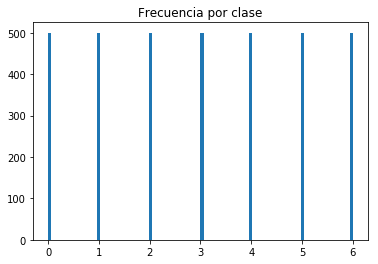

In [374]:
ageClass = data_train[1] #target
target_to_class = {'1':0,'5':1,'10':2,'16':3,'28':4,'51':5,'75':6}
targets = ageClass.reshape(-1).astype(int)
classes = np.zeros(len(targets))
targets_vector = [1,5,10,16,28,51,75]

for i in range(len(targets)):
    classes[i] = target_to_class[str(targets[i])]
plt.hist(classes,bins= 100)
plt.title('Frecuencia por clase')
plt.show()

Por último, observamos que tenemos en nuestras manos un problema de clases balanceadas.

In [344]:
results_file = open('pregunta3_results/results.txt', 'r')
results = []
for row in results_file:
    results.append(row.replace('t_u','t--u').replace('e_u','e--u').strip('\n').split('_'))
    
results_file_dropout = open('pregunta3_results/dropout_results.txt', 'r')
results_dropout = []
for row in results_file_dropout:
    results_dropout.append(row.replace('t_u','t--u').replace('e_u','e--u').strip('\n').split('_'))

In [349]:
results = pd.DataFrame(results)
results.columns = ['n_layers', 'neurons','activation','initializer','learning_rate','epochs','mse','val_mse','accuracy']
results_dropout = pd.DataFrame(results_dropout)
results_dropout.columns = ['n_layers', 'neurons','activation','initializer','learning_rate','epochs','mse','val_mse','accuracy']


In [358]:
results[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']] = \
results[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']].apply(pd.to_numeric)

In [350]:
results_dropout[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']] = \
results_dropout[['n_layers', 'neurons','learning_rate','epochs','mse','val_mse','accuracy']].apply(pd.to_numeric)

c) Defina y entrene una modelo de red neuronal *feed forward* para la inferencia de la edad de la persona a través de la representación escogida. Intente llegar a un *mse* menor a 100 en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.

**Nota: los modelos de esta sección fueron entrenados en el servidor del Laboratorio de Inteligencia Computacional Avanzada (INCA), por lo que en este notebook tan sólo se mostrarán los resultados obtenidos. 
La siguiente es la función utilizada en el servidor para construir los modelos y guardar los resultados obtenidos:** 

```python

import os
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1,l2
import numpy as np
import scipy.io as sio
from itertools import product
import random

random.seed(9001)

#import keras.callbacks.EarlyStopping
callback = [keras.callbacks.EarlyStopping(patience=5)]
mat_train = sio.loadmat("eventrain.mat")
mat_test = sio.loadmat("eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

genFeat = data_train[0]  #it can be used as representation: contextual features
ageClass = data_train[1] #target
genClass = data_train[2]
ffcoefs = data_train[3]   #it can be used as representation: fisherface space
faceGist = data_train[4]  #it can be used as representation
ffimg = data_train[5]

target_to_class = {'1':0,'5':1,'10':2,'16':3,'28':4,'51':5,'75':6}
targets = ageClass.reshape(-1).astype(int)
classes = np.zeros(len(targets))
targets_vector = [1,5,10,16,28,51,75]

for i in range(len(targets)):
    classes[i] = target_to_class[str(targets[i])]
    
    
features = []
for i in range(5):
    if i == 1 or i == 8:
        continue
    #print(data_train[i].shape)
    features.append(data_train[i])
    
data = np.concatenate(features,axis=1)
scaler = StandardScaler().fit(data)
data =  scaler.transform(data)

shuffle = np.random.choice(len(data),len(data),replace=False)
data = data[shuffle]
classes = classes[shuffle]
targets = targets[shuffle]

n_val = 700
test = data[-n_val:] 
data = data[:-n_val]
classes_test = classes[-n_val:]
classes = classes[:-n_val]
targets_test = targets[-n_val:]
targets = targets[:-n_val]


n_layers = [1,2,3,4]
neurons = [10,20,30,100]
activation = ['sigmoid','relu']
initializer = ['uniform','glorot_uniform','he_uniform']
lr = [0.01, 0.001, 0.0001]
epochs = [1000]

parameters = product(n_layers, neurons, activation, initializer, lr, epochs)
parameters = [params for params in parameters]

for index,param in enumerate(parameters):
    
    print(index)
    n_layers = param[0]
    neurons = param[1]
    activation = param[2]
    initializer = param[3]
    lr = param[4]
    epochs = param[5]

    inputs = Input(shape=(data.shape[1],))
    dummy  = Dropout(0.5)(inputs)

    
    for i in range(n_layers):
         dense = Dense(neurons, activation=activation, \
                       kernel_initializer=initializer)(dummy)
         
         dummy = Dropout(0.5)(dense)

    
    outputs = Dense(7, kernel_initializer=initializer, activation='softmax')(dummy)
    model = Model(inputs=inputs, outputs=outputs)
    
    adam = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam)
    one_hot = keras.utils.to_categorical(classes, num_classes=7)
    one_hot_test = keras.utils.to_categorical(classes_test, num_classes=7)
    
    history = model.fit(data, one_hot, epochs=epochs, batch_size = 32, callbacks = callback, \
              verbose = False,validation_data=(test,one_hot_test))
    
    one_hot_predictions = model.predict(data)
    one_hot_predictions = np.argmax(one_hot_predictions,axis=1)
    predictions = keras.utils.to_categorical(one_hot_predictions, num_classes=7)
    predictions = np.dot(predictions,targets_vector)
    train_mse = np.mean((predictions.flatten() - targets.flatten())**2) 
    
    name = '{}_{}_{}_{}_{}_{}'.format(n_layers,neurons,activation,initializer,lr,epochs)
    
    model.save('pregunta3_results/'+name+'.h5')
    np.savetxt('pregunta3_results/history'+name+'.txt',history.history['loss'])
    one_hot_predictions = model.predict(test)
    one_hot_predictions = np.argmax(one_hot_predictions,axis=1)
    predictions = keras.utils.to_categorical(one_hot_predictions, num_classes=7)
    predictions = np.dot(predictions,targets_vector)
    test_mse = np.mean((predictions.flatten() - targets_test.flatten())**2) 
    accuracy= np.sum((predictions - targets_test) == 0)/len(predictions)
    
    with open("pregunta3_results/dropout_results.txt", "a") as myfile:
        myfile.write('{}_{}_{}_{}\n'.format(name,train_mse,test_mse,accuracy))
    
```   
     
     
     
     
     
     
     
     
    

Los parámetros que han sido utilizados, en todas sus posibles combinaciones son:
- Número de capas: 1, 2, 3 y 4.
- Número de neuronas por capa: 10, 20, 30, y 40; 100 sólo para dropout.
- Activaciones: sigmoid y ReLu.
- Inicilizadores: uniform, glorot uniform y he uniform.
- Learning rate: 0.01, 0.001, 0.0001.
- Epochs: 1000, pero con early stopping.
- Dropout: 0 o 0.5

El problema ha sido tratado como un problema de clasificación. Los resultados se muestran en las siguientes tablas:

### Resultados sin dropout

In [359]:
results

,n_layers,neurons,activation,initializer,learning_rate,epochs,mse,val_mse,accuracy
0,1,10,sigmoid,uniform,0.0100,1000,249.667143,444.350000,0.452857
1,1,10,sigmoid,uniform,0.0010,1000,201.698571,351.070000,0.485714
2,1,10,sigmoid,uniform,0.0001,1000,224.269286,360.631429,0.488571
3,1,10,sigmoid,glorot--uniform,0.0100,1000,234.186071,414.431429,0.435714
4,1,10,sigmoid,glorot--uniform,0.0010,1000,226.555714,381.601429,0.482857
5,1,10,sigmoid,glorot--uniform,0.0001,1000,227.271429,340.888571,0.480000
6,1,10,sigmoid,he--uniform,0.0100,1000,252.648929,398.650000,0.478571
7,1,10,sigmoid,he--uniform,0.0010,1000,201.028929,339.532857,0.505714
8,1,10,sigmoid,he--uniform,0.0001,1000,258.905000,391.000000,0.457143
9,1,10,relu,uniform,0.0100,1000,237.296786,387.181429,0.481429


In [364]:
results.iloc[np.argmin(results['val_mse'])]

n_layers                2
neurons                10
activation           relu
initializer       uniform
learning_rate       0.001
epochs               1000
mse               207.399
val_mse           313.299
accuracy         0.457143
Name: 64, dtype: object

Como se puede observar, el menor error de validación es de 313, lo cual está lejos de lo solicitado. Sin embargo, notamos que el accuracy es similar al obtenido en el paper original a partir del cual se extrajeron los datos, por lo que creemos que, dadas las características utilizadas para resolver el problema, el mse obtenido está en el rango de lo esperable.

### Resultados con dropout

In [351]:
results_dropout

,n_layers,neurons,activation,initializer,learning_rate,epochs,mse,val_mse,accuracy
0,1,10,sigmoid,uniform,0.0100,1000,433.062857,513.187143,0.404286
1,1,10,sigmoid,uniform,0.0010,1000,338.170714,429.635714,0.454286
2,1,10,sigmoid,uniform,0.0001,1000,380.636429,470.017143,0.437143
3,1,10,sigmoid,glorot--uniform,0.0100,1000,472.415357,586.415714,0.392857
4,1,10,sigmoid,glorot--uniform,0.0010,1000,345.019643,428.122857,0.435714
5,1,10,sigmoid,glorot--uniform,0.0001,1000,355.676071,472.547143,0.448571
6,1,10,sigmoid,he--uniform,0.0100,1000,467.201786,573.167143,0.407143
7,1,10,sigmoid,he--uniform,0.0010,1000,370.120000,462.075714,0.444286
8,1,10,sigmoid,he--uniform,0.0001,1000,387.209286,476.978571,0.424286
9,1,10,relu,uniform,0.0100,1000,338.361786,394.865714,0.395714


In [365]:
results_dropout.iloc[np.argmin(results_dropout['val_mse'])]

n_layers                3
neurons               100
activation           relu
initializer       uniform
learning_rate      0.0001
epochs               1000
mse               210.599
val_mse            382.33
accuracy         0.461429
Name: 209, dtype: object

Pese a la utilización de Dropout, la cual es considerada una técnica potente para evitar sobre-ajuste, esto no sirvió para mejorar el mse del conjunto de validación. Cabe destacar la diferencia entre la arquitectura con y sin Dropout de la mejor red en cada caso: sin Dropout, 2 capas y 10 neuronas cada una lograron el mejor resultado, mientras que con Dropout, se necesitaron 3 capas y 100 neuronas. Esto se puede explicar si consideramos que las características latentes implicitas en la ReLu son sparse, y al aplicar Dropout, este efecto se magnifica. Por ende, para representar las mismas características, se requieren más neuronas por capa.